step 1 - import data, libraries, etc
step 2 - summarize and clean data
step 4 - encode categorical variables
step 3 - visualize data
step 7 - generate decision tree
step 5 - create test and training sets
step 6 - score test data and tweak parameters


Insurance companies have high charges for smokers, especially when smokers have high BMI. Data visualizations reveal this, and the decission tree bears it out. The Partial dependence plot reveals that there is a huge change in charges when BMI crosses 30. For some, these jumps are much higher, which is likely due to smoking status. 

Having a high number of children seems from the data visualizations to reduce the cost of insurance, which is counterintuitive given the cost of birth, but I'm wondering if this may have to do with how the figures are calculated. 

In [519]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import category_encoders as ce
import matplotlib.pyplot as pl
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from pdpbox import pdp, info_plots
from sklearn.pipeline import make_pipeline
import sklearn

df = pd.read_csv('/Users/liamsweeney/dat-11-15/Homework/Unit2/data/insurance_premiums.csv')

In [422]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [423]:
#checking for null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [424]:
#looking at median for floats
df.median()

age           39.000
bmi           30.400
children       1.000
charges     9382.033
dtype: float64

In [425]:
#looking at standard deviation
df.std()

age            14.049960
bmi             6.098187
children        1.205493
charges     12110.011237
dtype: float64

In [426]:
#because sex and smoker are binary, I want to one hot encode them. I'd rather not do this for region because it has multiple categories
categorical = ['sex', 'smoker']

In [427]:
df_ohe = pd.get_dummies(df, columns=categorical)

In [428]:
df_ohe

,age,bmi,children,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,southwest,16884.92400,1,0,0,1
1,18,33.770,1,southeast,1725.55230,0,1,1,0
2,28,33.000,3,southeast,4449.46200,0,1,1,0
3,33,22.705,0,northwest,21984.47061,0,1,1,0
4,32,28.880,0,northwest,3866.85520,0,1,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,northwest,10600.54830,0,1,1,0
1334,18,31.920,0,northeast,2205.98080,1,0,1,0
1335,18,36.850,0,southeast,1629.83350,1,0,1,0
1336,21,25.800,0,southwest,2007.94500,1,0,1,0


In [429]:
#so I will ordinal encode region
ore = ce.OrdinalEncoder(mapping = [
    {
        'col': 'region',
        'mapping': {'northeast': 1, 'northwest': 2, 'southeast': 3, 'southwest': 4}
    }
])

In [430]:
#and call the transformed data set df_ce
df_ce = ore.fit_transform(df_ohe)

In [431]:
df_ce

,age,bmi,children,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,4,16884.92400,1,0,0,1
1,18,33.770,1,3,1725.55230,0,1,1,0
2,28,33.000,3,3,4449.46200,0,1,1,0
3,33,22.705,0,2,21984.47061,0,1,1,0
4,32,28.880,0,2,3866.85520,0,1,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,2,10600.54830,0,1,1,0
1334,18,31.920,0,1,2205.98080,1,0,1,0
1335,18,36.850,0,3,1629.83350,1,0,1,0
1336,21,25.800,0,4,2007.94500,1,0,1,0


In [489]:
#not sure if this will be useful for creating new columns, but imo it never hurts to have a count column
df_ce['count'] = 1

In [490]:
df_ce

,age,bmi,children,region,charges,sex_female,sex_male,smoker_no,smoker_yes,count
0,19,27.900,0,4,16884.92400,1,0,0,1,1
1,18,33.770,1,3,1725.55230,0,1,1,0,1
2,28,33.000,3,3,4449.46200,0,1,1,0,1
3,33,22.705,0,2,21984.47061,0,1,1,0,1
4,32,28.880,0,2,3866.85520,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,2,10600.54830,0,1,1,0,1
1334,18,31.920,0,1,2205.98080,1,0,1,0,1
1335,18,36.850,0,3,1629.83350,1,0,1,0,1
1336,21,25.800,0,4,2007.94500,1,0,1,0,1


In [432]:
#Now I'm just going to do some groupings looking at the mean to get a basic idea of what the data is saying across a few cols
grouping_sm_ch = df_ce.groupby(['smoker_yes', 'children']).mean()[['charges']].reset_index()

In [433]:
grouping_children = df_ce.groupby(['children']).mean()['charges'].reset_index()

In [434]:
grouping_bmi = df_ce.groupby(['bmi']).mean()['charges'].reset_index()

In [487]:
grouping_sex = df.groupby(['sex']).mean()['charges'].reset_index()

In [494]:
grouping_region = df.groupby(['region']).mean()['charges'].reset_index()

In [495]:
#lowest charges in sw, highest in se
grouping_region

,region,charges
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


In [488]:
#closer than I would have thought
grouping_sex

,sex,charges
0,female,12569.578844
1,male,13956.751178


In [435]:
#whoa, smoking is bad for you eh? but slightly less so if you have lots of kids? weirdly having lots of kids lowers insurance costs? is this because cost is divided?
grouping_sm_ch

,smoker_yes,children,charges
0,0,0,7611.793335
1,0,1,8303.109350
2,0,2,9493.093674
3,0,3,9614.519391
4,0,4,12121.344408
5,0,5,8183.845556
6,1,0,31341.363954
7,1,1,31822.654334
8,1,2,33844.235755
9,1,3,32724.915268


In [436]:
grouping_children

,children,charges
0,0,12365.975602
1,1,12731.171832
2,2,15073.563734
3,3,15355.318367
4,4,13850.656311
5,5,8786.035247


In [437]:
#bmi has too many categories to group. lets look at a histogram
grouping_bmi

,bmi,charges
0,15.960,1694.796400
1,16.815,4904.000350
2,17.195,14455.644050
3,17.290,7813.353433
4,17.385,2775.192150
...,...,...
543,48.070,9432.925300
544,49.060,11381.325400
545,50.380,2438.055200
546,52.580,44501.398200


In [499]:
df_ce["charges"] = df_ce["charges"].astype(float)

In [507]:
#pretty normal distribution
fig = px.histogram(df_ce, x="bmi", title = "Body Mass Index Histogram")
fig.show()

In [509]:
#higher charges for higher bmi
fig = px.scatter(df, x="bmi", y="charges", title = "Body Mass Index/Charges: Scatter Plot")
fig.show()

In [510]:
#n is diffeent for sex but pattern tracks across both male and female 
fig = px.histogram(df, x="charges", color = "sex", nbins = 30, title = "Sex/Charges: Histogram")
fig.show()

In [511]:
#smoking is very bad for you - i am quitting.
fig = px.scatter(df, x="age", y="charges", color="smoker", size = "bmi", title = "Age/Charges: Scatter Plot - color: smoker, size: bmi")
fig.show()

In [512]:
#smoking and high bmi is especially bad for you
fig = px.scatter(df, x="bmi", y="charges", color="smoker", size = "age", title = "Body Mass Index/Charges: Scatter Plot - color: smoker, size: age")
fig.show()

In [513]:
#aesthetically interested in this as it kind of looks like a carbonated beverage
fig = px.scatter(df, x="bmi", y="age", color="smoker", size = "charges", title = 'Body Mass Index/Age: Scatter Plot - color: smoker, size: charges')
fig.show()

In [444]:
#making a tree with depth of 3 so we can see something
tree_1 = DecisionTreeRegressor(max_depth = 3)

In [445]:
X = df_ce.drop("charges", axis = 1)
y = df_ce["charges"]

In [446]:
tree_1.fit(X, y)

DecisionTreeRegressor(max_depth=3)

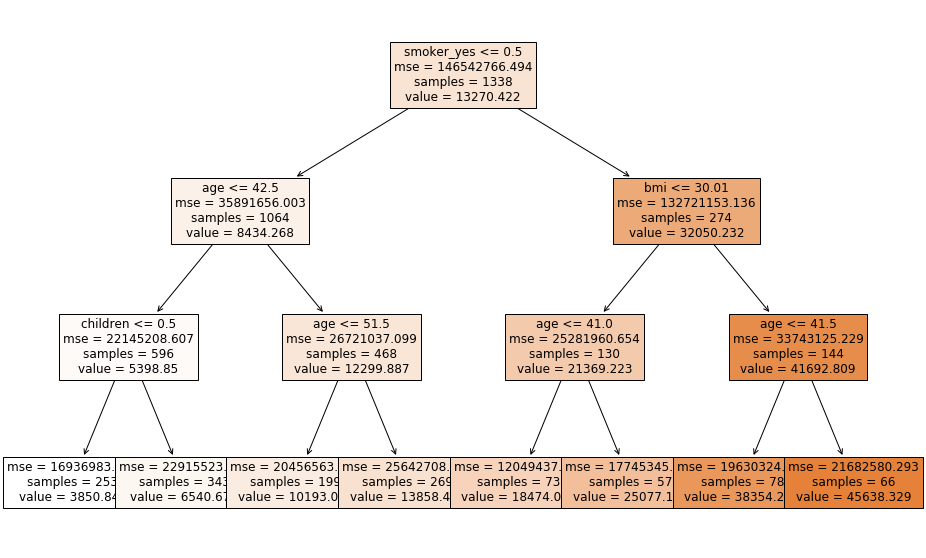

In [447]:
#this confirms smoker, bmi significance. I think there's a lot of value in showing the visualization and then backing it up with the data from the tree. 
plt.figure(figsize = (16, 10))

plot_tree(tree_1, filled = True, fontsize = 12, feature_names = X.columns);

In [448]:
#making a training and test set. I found this method on the internet, hopefully it doesn't mess me up
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.15, random_state=42)

In [449]:
#scoring the test set
tree_1.score(X_test, y_test)

0.8767519419513771

In [521]:
#making a function to check the score for different depths
def scoring_trees_d(depth):
    tree_1 = DecisionTreeRegressor(max_depth = depth)
    tree_1.fit(X_train, y_train)
    return tree_1.score(X_test, y_test)


In [522]:
#same for splits
def scoring_trees_s(split):
    tree_1 = DecisionTreeRegressor(min_samples_split = split)
    tree_1.fit(X_train, y_train)
    return tree_1.score(X_test, y_test)

In [523]:
# depth of 4 looks good
print(scoring_trees_d(1))
print(scoring_trees_d(2))
print(scoring_trees_d(3))
print(scoring_trees_d(4))
print(scoring_trees_d(5))
print(scoring_trees_d(6))
print(scoring_trees_d(7))

0.6765874233986269
0.8375795586801075
0.8487201249618305
0.8577775157041303
0.8196573495554103
0.8045326773314048
0.7776608153910622


In [524]:
# split of 6
print(scoring_trees_s(2))
print(scoring_trees_s(3))
print(scoring_trees_s(4))
print(scoring_trees_s(5))
print(scoring_trees_s(6))

0.7254238588019074
0.7205587629319585
0.7449210906887159
0.7437148761851795
0.7573271966435733


In [406]:
#I want to take a look at test predictions. I'm noticing that 764, 1293, 351 are in the same bin. 
X_test['Prediction'] = tree.predict(X_test)

In [407]:
X_test['Prediction']

764     10193.096602
887      3850.841264
890     25077.112770
1293    10193.096602
259     38354.292272
            ...     
636      6540.675053
1073    13858.441867
31       3850.841264
351     10193.096602
1137     3850.841264
Name: Prediction, Length: 201, dtype: float64

In [408]:
#whereas y numbers are all unique
y_test

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
           ...     
636      2709.11190
1073    12096.65120
31       2198.18985
351      8932.08400
1137     3176.28770
Name: charges, Length: 201, dtype: float64

In [525]:
#so now that I figured out that max depth of 7 is best I'm going to fit a new tree with that depth. 2 is the default split so no need to do anything there.
tree_2 = DecisionTreeRegressor(max_depth = 4, min_samples_split = 6)

In [526]:
tree_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_split=6)

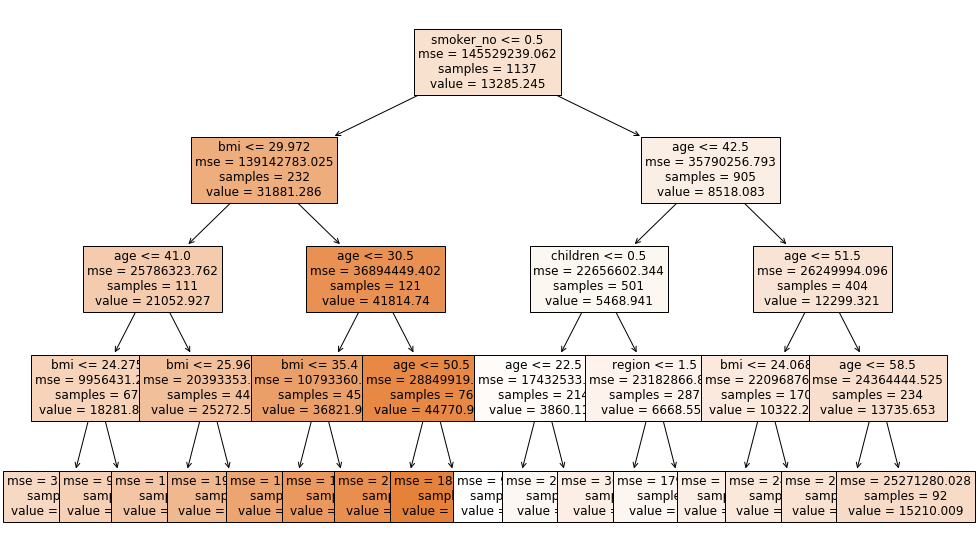

In [527]:
plt.figure(figsize = (16, 10))

plot_tree(tree_2, filled = True, fontsize = 12, feature_names = X.columns);

In [528]:
#this score is not as high as I thought it would be but it is higher than the training set. 
tree_2.score(X_train, y_train)

0.8671282317089422

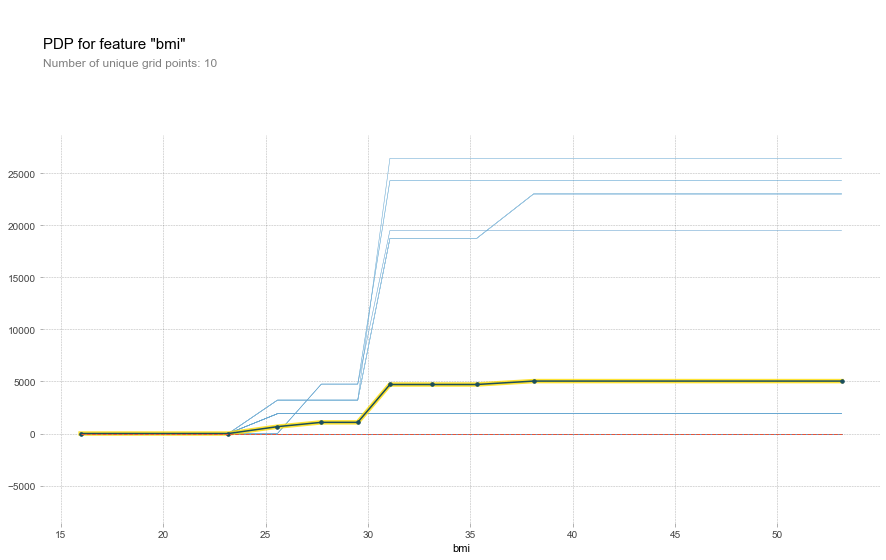

In [531]:
pdp_day_of_week = pdp.pdp_isolate(
    model=tree_2, dataset=X_train, model_features=X_train.columns.tolist(), 
    feature='bmi', #cust_grid_points = X_train['charges'].unique().tolist() # use this if you want to plot every unique value
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'bmi', plot_lines=True, frac_to_plot=100)

,age,bmi,children,region,sex_female,sex_male,smoker_no,smoker_yes
331,52,27.360,0,2,0,1,0,1
796,30,44.220,2,3,0,1,1,0
1039,19,27.265,2,2,0,1,1,0
261,20,26.840,1,3,1,0,0,1
70,27,24.750,0,3,1,0,0,1
...,...,...,...,...,...,...,...,...
1095,18,31.350,4,1,1,0,1,0
1130,39,23.870,5,3,1,0,1,0
1294,58,25.175,0,1,0,1,1,0
860,37,47.600,2,4,1,0,0,1
